In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
!tar -xvf WISDM_ar_latest.tar.gz

Downloading...
From: https://drive.google.com/uc?id=152sWECukjvLerrVG2NUO8gtMFg83RKCF
To: /content/WISDM_ar_latest.tar.gz
11.4MB [00:00, 69.7MB/s]
WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [ ]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)

In [ ]:
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [ ]:
df.z_axis.replace(regex=True,inplace=True,to_replace=r';',value=r'')
df['z_axis']=df.z_axis.astype(np.float64)
df.dropna(axis=0,how='any',inplace=True)

In [ ]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
df.shape

(1098203, 6)

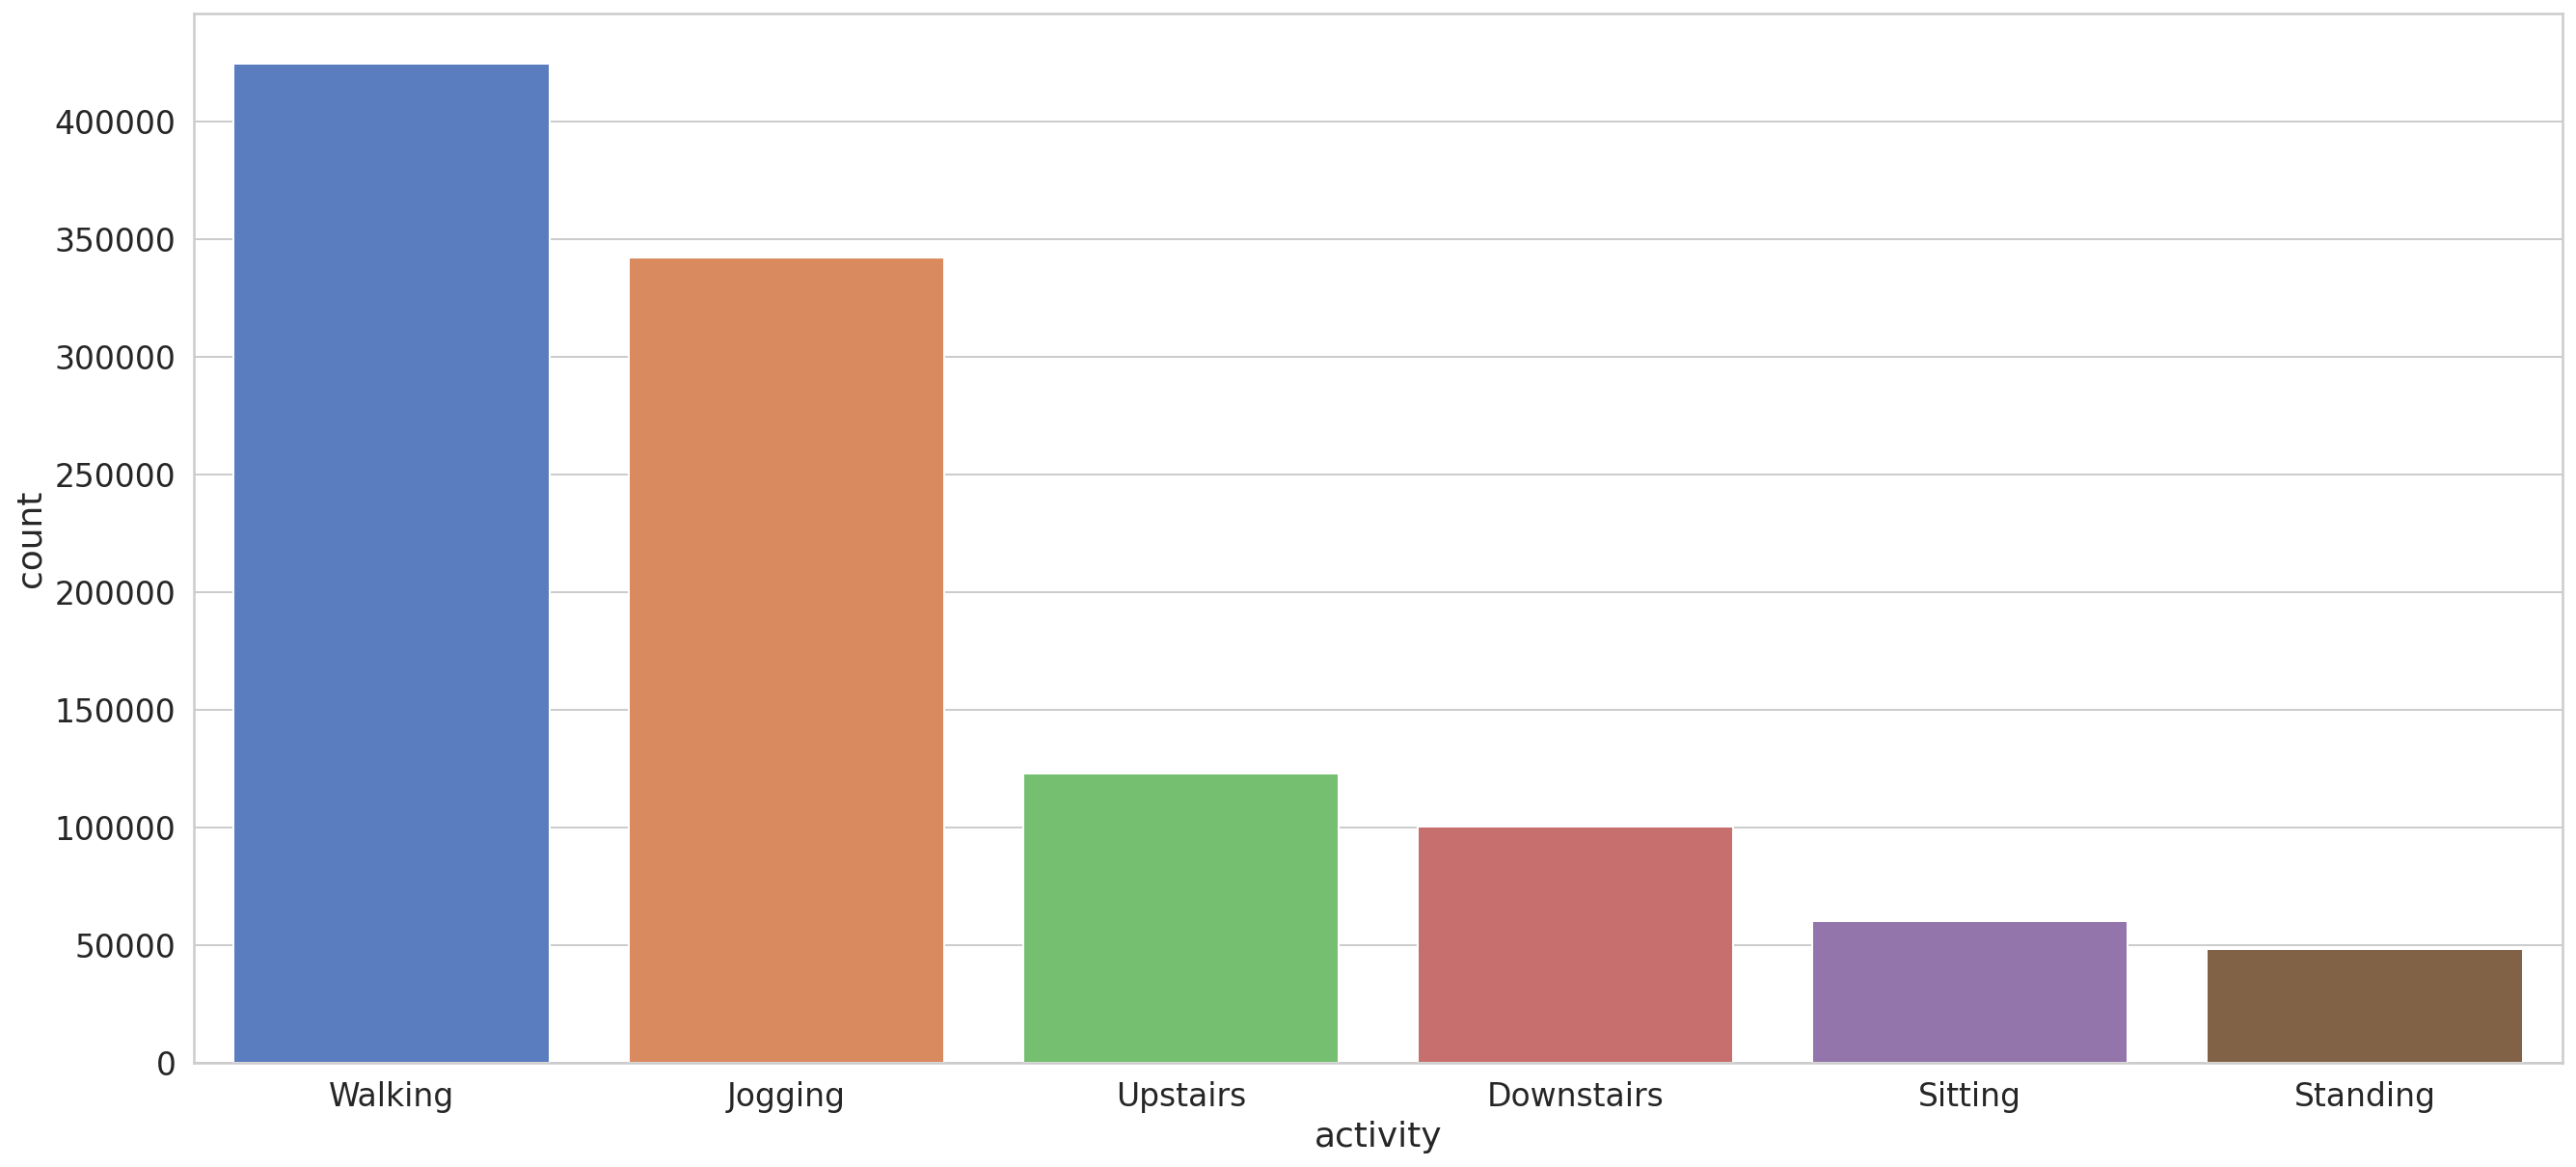

In [ ]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

In [ ]:
df_train=df[df['user_id']<=30]
df_test=df[df['user_id']>30]

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
scale_columns=['x_axis','y_axis','z_axis']
scaler=RobustScaler()
scaler=scaler.fit(df_train[scale_columns])
df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
df_train

In [ ]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [ ]:
X_train.shape

(22454, 200, 3)

In [ ]:
y_train[0]

array(['Walking'], dtype='<U10')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
enc=enc.fit(y_train)
y_train=enc.transform(y_train)
y_test=enc.transform(y_test)

In [ ]:
print(df_train.activity.iloc[:200])

In [ ]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/20
316/316 [==============================] - 8s 26ms/step - loss: 1.0625 - acc: 0.6396 - val_loss: 0.9599 - val_acc: 0.7364
Epoch 2/20
316/316 [==============================] - 8s 24ms/step - loss: 0.9336 - acc: 0.6804 - val_loss: 0.9745 - val_acc: 0.7364
Epoch 3/20
316/316 [==============================] - 8s 25ms/step - loss: 0.7994 - acc: 0.7258 - val_loss: 0.8663 - val_acc: 0.7524
Epoch 4/20
316/316 [==============================] - 8s 25ms/step - loss: 0.6685 - acc: 0.7575 - val_loss: 0.4782 - val_acc: 0.8308
Epoch 5/20
316/316 [==============================] - 8s 25ms/step - loss: 0.5367 - acc: 0.8024 - val_loss: 0.6653 - val_acc: 0.8290
Epoch 6/20
316/316 [==============================] - 8s 25ms/step - loss: 0.4477 - acc: 0.8321 - val_loss: 0.4535 - val_acc: 0.8464
Epoch 7/20
316/316 [==============================] - 8s 25ms/step - loss: 0.3881 - acc: 0.8547 - val_loss: 0.5470 - val_acc: 0.8197
Epoch 8/20
316/316 [==============================] - 8s 25ms/step - 